In [1]:
import warnings, os
import numpy as np
import pandas as pd
from nbeats_keras.model import NBeatsNet as NBeatsKeras
warnings.filterwarnings(action='ignore', message='Setting attributes')
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
config = tf.compat.v1.ConfigProto() # Another Version: config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [3]:
# plot utils.
def plot_scatter(*args, **kwargs):
    plt.plot(*args, **kwargs)
    plt.scatter(*args, **kwargs)


# simple batcher.
def data_generator(x, y, size):
    assert len(x) == len(y)
    batches = []
    for ii in range(0, len(x), size):
        batches.append((x[ii:ii + size], y[ii:ii + size]))
    for batch in batches:
        yield batch

        
def MinMaxScaler(data):
  """Min Max normalizer.
  
  Args:
    - data: original data
  
  Returns:
    - norm_data: normalized data
  """
  numerator = data - np.min(data, 0)
  denominator = np.max(data, 0) - np.min(data, 0)
  norm_data = numerator / (denominator + 1e-7)
  return norm_data
        
# to load real data        
def real_data_loading (data_name, seq_len):
  """Load and preprocess real-world datasets.
  
  Args:
    - data_name: stock or energy
    - seq_len: sequence length
    
  Returns:
    - data: preprocessed data.
  """  

  assert data_name in ['stock','energy']
  
  if data_name == 'stock':
    ori_data = np.loadtxt('/data/home/stufs1/zuwang/dg21/TimeGAN/data/stock_data.csv', delimiter = ",",skiprows = 1)
  elif data_name == 'energy':
    ori_data = np.loadtxt('/data/home/stufs1/zuwang/dg21/TimeGAN/data/energy_data.csv', delimiter = ",",skiprows = 1)
        
  # Flip the data to make chronological data
  ori_data = ori_data[::-1]
  # Normalize the data
  ori_data = MinMaxScaler(ori_data)
    
  # Preprocess the dataset
  temp_data = []    
  # Cut data by sequence length
  for i in range(0, len(ori_data) - seq_len):
    _x = ori_data[i:i + seq_len]
    temp_data.append(_x)
        
  # Mix the datasets (to make it similar to i.i.d)
  idx = np.random.permutation(len(temp_data))    
  data = []
  for i in range(len(temp_data)):
    data.append(temp_data[idx[i]])
    
  return data

In [4]:
# load the generated data -- TimeGAN
src_path = "/data/home/stufs1/zuwang/dg21/TimeGAN/"
file_name = "stock_data.npy"

syn_data = np.load(os.path.join(src_path, file_name))
print("synthetic data shape:", syn_data.shape) # (no, seq_len, dim)

synthetic data shape: (3661, 24, 6)


In [5]:
# load the real data -- TimeGAN
data_name = "stock"
seq_len = 24
ori_data = real_data_loading(data_name, seq_len) # 
ori_data = np.asarray(ori_data)
print("real data shape:", ori_data.shape) # (no, seq_len, dim)

real data shape: (3661, 24, 6)


In [6]:
'''
# load the real data
milk = pd.read_csv('data/milk.csv', index_col=0, parse_dates=True)
print(milk.head())
milk = milk.values.flatten()  # just keep np array here for simplicity

# milk-shape: (168,)
'''

"\n# load the real data\nmilk = pd.read_csv('data/milk.csv', index_col=0, parse_dates=True)\nprint(milk.head())\nmilk = milk.values.flatten()  # just keep np array here for simplicity\n\n# milk-shape: (168,)\n"

In [7]:
num_samples, time_steps, input_dim, output_dim = 3661, 24, 6, 6
backend = NBeatsKeras(
        input_dim=input_dim,
        backcast_length=19, forecast_length=5,
        stack_types=(NBeatsKeras.GENERIC_BLOCK, NBeatsKeras.GENERIC_BLOCK),
        nb_blocks_per_stack=2, thetas_dim=(4, 4), share_weights_in_stack=True,
        hidden_layer_units=64
    )

# Definition of the objective function and the optimizer.
backend.compile(loss='mae', optimizer='adam')

forecast_length = 5
backcast_length = 19

#### Stock-TimeGAN
# x: data backcast/y: forecast generation.

x_train, y_train = [], []
for i in range(len(syn_data)):
    x_train.append(syn_data[i][:19,:])
    y_train.append(syn_data[i][19:,:])

x_test, y_test = [], []
for i in range(len(ori_data)):
    x_test.append(ori_data[i][:19,:])
    y_test.append(ori_data[i][19:,:])

# normalization.
norm_constant = np.max(x_train)
x_train, y_train = x_train / norm_constant, y_train / norm_constant
x_test, y_test = x_test / norm_constant, y_test / norm_constant
test_size = len(x_test)
print("test_size is:", test_size)

test_size is: 3661


In [8]:
# check the model data shape
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3661, 19, 6), (3661, 5, 6), (3661, 19, 6), (3661, 5, 6))

In [9]:
# Train the model.
print('Training...')
backend.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5000, batch_size=128)

# Save the model for later.
backend.save('n_beats_model.h5')

# Predict on the testing set (forecast).
predictions_forecast = backend.predict(x_test)
print("the prediction_forecast shape is:", predictions_forecast.shape) #shape: (30, 5, 1)
#np.testing.assert_equal(predictions_forecast.shape, (test_size, backend.forecast_length, output_dim))

# Predict on the testing set (backcast).
predictions_backcast = backend.predict(x_test, return_backcast=True)
print("the prediction_backcast shape is:", predictions_backcast.shape) #shape: (30, 15, 1)
#np.testing.assert_equal(predictions_backcast.shape, (test_size, backend.backcast_length, output_dim))

# Load the model.
model_2 = NBeatsKeras.load('n_beats_model.h5')
predicts = model_2.predict(x_test)
print("the reloaded prediction_shape is:", predicts.shape) #shape: (30, 5, 1)
#np.testing.assert_almost_equal(predictions_forecast, model_2.predict(x_test))

Training...
Epoch 1/5000
29/29 [==============================] - 20s 125ms/step - loss: 0.4468 - val_loss: 0.4035
Epoch 2/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.2221 - val_loss: 0.3104
Epoch 3/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1892 - val_loss: 0.2801
Epoch 4/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1669 - val_loss: 0.2921
Epoch 5/5000
29/29 [==============================] - 0s 9ms/step - loss: 0.1590 - val_loss: 0.2883
Epoch 6/5000
29/29 [==============================] - 0s 9ms/step - loss: 0.1555 - val_loss: 0.2822
Epoch 7/5000
29/29 [==============================] - 0s 9ms/step - loss: 0.1525 - val_loss: 0.2818
Epoch 8/5000
29/29 [==============================] - 0s 9ms/step - loss: 0.1533 - val_loss: 0.2803
Epoch 9/5000
29/29 [==============================] - 0s 9ms/step - loss: 0.1531 - val_loss: 0.2739
Epoch 10/5000
29/29 [==============================] - 0s 9ms/step - loss: 0.1499 

29/29 [==============================] - 0s 10ms/step - loss: 0.1430 - val_loss: 0.2540
Epoch 82/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1421 - val_loss: 0.2643
Epoch 83/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1798 - val_loss: 0.3067
Epoch 84/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1612 - val_loss: 0.2870
Epoch 85/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1509 - val_loss: 0.2700
Epoch 86/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1483 - val_loss: 0.2726
Epoch 87/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1475 - val_loss: 0.2731
Epoch 88/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1453 - val_loss: 0.2704
Epoch 89/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1430 - val_loss: 0.2735
Epoch 90/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1451 - val_loss: 0

Epoch 161/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1434 - val_loss: 0.2675
Epoch 162/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1445 - val_loss: 0.2652
Epoch 163/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1566 - val_loss: 0.2695
Epoch 164/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1499 - val_loss: 0.2649
Epoch 165/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1424 - val_loss: 0.2661
Epoch 166/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1463 - val_loss: 0.2567
Epoch 167/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1536 - val_loss: 0.2672
Epoch 168/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1460 - val_loss: 0.2641
Epoch 169/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1445 - val_loss: 0.2680
Epoch 170/5000
29/29 [==============================] - 0s 11ms/step - lo

29/29 [==============================] - 0s 9ms/step - loss: 0.1408 - val_loss: 0.2645
Epoch 241/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1388 - val_loss: 0.2601
Epoch 242/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1489 - val_loss: 0.3151
Epoch 243/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1754 - val_loss: 0.3237
Epoch 244/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1542 - val_loss: 0.2959
Epoch 245/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1492 - val_loss: 0.2782
Epoch 246/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1463 - val_loss: 0.2802
Epoch 247/5000
29/29 [==============================] - 0s 9ms/step - loss: 0.1470 - val_loss: 0.2713
Epoch 248/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1457 - val_loss: 0.2756
Epoch 249/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1456 - val_

29/29 [==============================] - 0s 10ms/step - loss: 0.1445 - val_loss: 0.2873
Epoch 320/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1406 - val_loss: 0.2779
Epoch 321/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1441 - val_loss: 0.2921
Epoch 322/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1503 - val_loss: 0.2856
Epoch 323/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1449 - val_loss: 0.2896
Epoch 324/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1535 - val_loss: 0.3137
Epoch 325/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1509 - val_loss: 0.2834
Epoch 326/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1468 - val_loss: 0.2821
Epoch 327/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1449 - val_loss: 0.2751
Epoch 328/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1422 - va

29/29 [==============================] - 0s 10ms/step - loss: 0.1439 - val_loss: 0.2624
Epoch 399/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1407 - val_loss: 0.2610
Epoch 400/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1413 - val_loss: 0.2624
Epoch 401/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1467 - val_loss: 0.2527
Epoch 402/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1411 - val_loss: 0.2580
Epoch 403/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1405 - val_loss: 0.2525
Epoch 404/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1502 - val_loss: 0.2489
Epoch 405/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1432 - val_loss: 0.2513
Epoch 406/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1438 - val_loss: 0.2659
Epoch 407/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1411 - va

29/29 [==============================] - 0s 10ms/step - loss: 0.1387 - val_loss: 0.2604
Epoch 478/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1406 - val_loss: 0.2565
Epoch 479/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1464 - val_loss: 0.2597
Epoch 480/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1433 - val_loss: 0.2682
Epoch 481/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1382 - val_loss: 0.2639
Epoch 482/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1394 - val_loss: 0.2577
Epoch 483/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1421 - val_loss: 0.2651
Epoch 484/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1419 - val_loss: 0.2719
Epoch 485/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1402 - val_loss: 0.2564
Epoch 486/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1428 - va

29/29 [==============================] - 0s 10ms/step - loss: 0.1415 - val_loss: 0.2898
Epoch 557/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1437 - val_loss: 0.2948
Epoch 558/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1439 - val_loss: 0.2763
Epoch 559/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1676 - val_loss: 0.2816
Epoch 560/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1509 - val_loss: 0.2796
Epoch 561/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1459 - val_loss: 0.2708
Epoch 562/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1469 - val_loss: 0.2682
Epoch 563/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1466 - val_loss: 0.2650
Epoch 564/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1474 - val_loss: 0.2657
Epoch 565/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1450 - va

29/29 [==============================] - 0s 11ms/step - loss: 0.1559 - val_loss: 0.3036
Epoch 636/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1494 - val_loss: 0.3019
Epoch 637/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1467 - val_loss: 0.3016
Epoch 638/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1475 - val_loss: 0.3036
Epoch 639/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1454 - val_loss: 0.2996
Epoch 640/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1437 - val_loss: 0.3043
Epoch 641/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1431 - val_loss: 0.3086
Epoch 642/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1413 - val_loss: 0.3276
Epoch 643/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1416 - val_loss: 0.3397
Epoch 644/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1411 - va

29/29 [==============================] - 0s 11ms/step - loss: 0.1432 - val_loss: 0.2530
Epoch 715/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1420 - val_loss: 0.2555
Epoch 716/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1412 - val_loss: 0.2629
Epoch 717/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1431 - val_loss: 0.2646
Epoch 718/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1407 - val_loss: 0.2634
Epoch 719/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1417 - val_loss: 0.2661
Epoch 720/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1406 - val_loss: 0.2658
Epoch 721/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1420 - val_loss: 0.2652
Epoch 722/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1402 - val_loss: 0.2692
Epoch 723/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1436 - va

29/29 [==============================] - 0s 10ms/step - loss: 0.1827 - val_loss: 0.3107
Epoch 794/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1474 - val_loss: 0.2990
Epoch 795/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1469 - val_loss: 0.2999
Epoch 796/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1460 - val_loss: 0.2814
Epoch 797/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1470 - val_loss: 0.2790
Epoch 798/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1412 - val_loss: 0.2782
Epoch 799/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1430 - val_loss: 0.2869
Epoch 800/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1440 - val_loss: 0.2829
Epoch 801/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1433 - val_loss: 0.2758
Epoch 802/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1421 - va

29/29 [==============================] - 0s 10ms/step - loss: 0.1367 - val_loss: 0.3198
Epoch 873/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1590 - val_loss: 0.2883
Epoch 874/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1586 - val_loss: 0.2961
Epoch 875/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1454 - val_loss: 0.3005
Epoch 876/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1479 - val_loss: 0.2968
Epoch 877/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1439 - val_loss: 0.2969
Epoch 878/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1463 - val_loss: 0.3055
Epoch 879/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1439 - val_loss: 0.3126
Epoch 880/5000
29/29 [==============================] - 0s 9ms/step - loss: 0.1415 - val_loss: 0.3236
Epoch 881/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1407 - val

29/29 [==============================] - 0s 10ms/step - loss: 0.1428 - val_loss: 0.3033
Epoch 952/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1416 - val_loss: 0.3056
Epoch 953/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1427 - val_loss: 0.3163
Epoch 954/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1395 - val_loss: 0.3234
Epoch 955/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1402 - val_loss: 0.3363
Epoch 956/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1397 - val_loss: 0.3579
Epoch 957/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1372 - val_loss: 0.3611
Epoch 958/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1362 - val_loss: 0.3230
Epoch 959/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1482 - val_loss: 0.3193
Epoch 960/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1422 - va

29/29 [==============================] - 0s 10ms/step - loss: 0.1388 - val_loss: 0.3595
Epoch 1031/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1388 - val_loss: 0.3626
Epoch 1032/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1415 - val_loss: 0.3586
Epoch 1033/5000
29/29 [==============================] - 0s 9ms/step - loss: 0.1394 - val_loss: 0.3775
Epoch 1034/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1397 - val_loss: 0.3821
Epoch 1035/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1388 - val_loss: 0.3795
Epoch 1036/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1399 - val_loss: 0.3658
Epoch 1037/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1389 - val_loss: 0.3725
Epoch 1038/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1378 - val_loss: 0.3785
Epoch 1039/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1

Epoch 1109/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1355 - val_loss: 0.3836
Epoch 1110/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1380 - val_loss: 0.3559
Epoch 1111/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1417 - val_loss: 0.3882
Epoch 1112/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1374 - val_loss: 0.3755
Epoch 1113/5000
29/29 [==============================] - 0s 9ms/step - loss: 0.1365 - val_loss: 0.3772
Epoch 1114/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1366 - val_loss: 0.3696
Epoch 1115/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1368 - val_loss: 0.3556
Epoch 1116/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1355 - val_loss: 0.3810
Epoch 1117/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1396 - val_loss: 0.3745
Epoch 1118/5000
29/29 [==============================] - 0s 10ms/

Epoch 1188/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1460 - val_loss: 0.3235
Epoch 1189/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1422 - val_loss: 0.3302
Epoch 1190/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1444 - val_loss: 0.3547
Epoch 1191/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1393 - val_loss: 0.3551
Epoch 1192/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1497 - val_loss: 0.3266
Epoch 1193/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1450 - val_loss: 0.3268
Epoch 1194/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1475 - val_loss: 0.3264
Epoch 1195/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1458 - val_loss: 0.3320
Epoch 1196/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1463 - val_loss: 0.3726
Epoch 1197/5000
29/29 [==============================] - 0s 10ms

Epoch 1267/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1394 - val_loss: 0.3159
Epoch 1268/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1388 - val_loss: 0.3203
Epoch 1269/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1394 - val_loss: 0.3231
Epoch 1270/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1370 - val_loss: 0.3318
Epoch 1271/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1418 - val_loss: 0.3140
Epoch 1272/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1394 - val_loss: 0.3230
Epoch 1273/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1381 - val_loss: 0.3314
Epoch 1274/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1367 - val_loss: 0.3149
Epoch 1275/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1406 - val_loss: 0.3262
Epoch 1276/5000
29/29 [==============================] - 0s 10ms

Epoch 1346/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1410 - val_loss: 0.2890
Epoch 1347/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1429 - val_loss: 0.2968
Epoch 1348/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1412 - val_loss: 0.3061
Epoch 1349/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1397 - val_loss: 0.3130
Epoch 1350/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1426 - val_loss: 0.3129
Epoch 1351/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1396 - val_loss: 0.3162
Epoch 1352/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1505 - val_loss: 0.3188
Epoch 1353/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1486 - val_loss: 0.2943
Epoch 1354/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1404 - val_loss: 0.3027
Epoch 1355/5000
29/29 [==============================] - 0s 10ms

Epoch 1425/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1528 - val_loss: 0.3077
Epoch 1426/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1431 - val_loss: 0.3103
Epoch 1427/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1433 - val_loss: 0.3306
Epoch 1428/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1383 - val_loss: 0.3129
Epoch 1429/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1438 - val_loss: 0.3108
Epoch 1430/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1399 - val_loss: 0.3206
Epoch 1431/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1420 - val_loss: 0.3129
Epoch 1432/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1381 - val_loss: 0.2806
Epoch 1433/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1447 - val_loss: 0.2997
Epoch 1434/5000
29/29 [==============================] - 0s 10ms

Epoch 1504/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1411 - val_loss: 0.3130
Epoch 1505/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1398 - val_loss: 0.3415
Epoch 1506/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1395 - val_loss: 0.3118
Epoch 1507/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1399 - val_loss: 0.3499
Epoch 1508/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1424 - val_loss: 0.3385
Epoch 1509/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1364 - val_loss: 0.3184
Epoch 1510/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1383 - val_loss: 0.3373
Epoch 1511/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1408 - val_loss: 0.2940
Epoch 1512/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1480 - val_loss: 0.2913
Epoch 1513/5000
29/29 [==============================] - 0s 11ms

Epoch 1583/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1385 - val_loss: 0.3013
Epoch 1584/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1436 - val_loss: 0.2861
Epoch 1585/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1439 - val_loss: 0.2983
Epoch 1586/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1407 - val_loss: 0.2985
Epoch 1587/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1369 - val_loss: 0.2962
Epoch 1588/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1346 - val_loss: 0.3007
Epoch 1589/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1735 - val_loss: 0.2791
Epoch 1590/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1512 - val_loss: 0.2744
Epoch 1591/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1484 - val_loss: 0.2769
Epoch 1592/5000
29/29 [==============================] - 0s 10ms

Epoch 1662/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1368 - val_loss: 0.2789
Epoch 1663/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1409 - val_loss: 0.2866
Epoch 1664/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1401 - val_loss: 0.2853
Epoch 1665/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1404 - val_loss: 0.2851
Epoch 1666/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1365 - val_loss: 0.2881
Epoch 1667/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1370 - val_loss: 0.2908
Epoch 1668/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1393 - val_loss: 0.2962
Epoch 1669/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1382 - val_loss: 0.2920
Epoch 1670/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1373 - val_loss: 0.2794
Epoch 1671/5000
29/29 [==============================] - 0s 10ms

Epoch 1741/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1381 - val_loss: 0.2919
Epoch 1742/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1372 - val_loss: 0.2898
Epoch 1743/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1356 - val_loss: 0.2943
Epoch 1744/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1337 - val_loss: 0.2929
Epoch 1745/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1423 - val_loss: 0.2977
Epoch 1746/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1626 - val_loss: 0.2650
Epoch 1747/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1525 - val_loss: 0.2669
Epoch 1748/5000
29/29 [==============================] - 0s 9ms/step - loss: 0.1509 - val_loss: 0.2642
Epoch 1749/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1470 - val_loss: 0.2659
Epoch 1750/5000
29/29 [==============================] - 0s 10ms/

Epoch 1820/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1413 - val_loss: 0.2909
Epoch 1821/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1365 - val_loss: 0.3052
Epoch 1822/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1369 - val_loss: 0.3081
Epoch 1823/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1354 - val_loss: 0.3031
Epoch 1824/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1383 - val_loss: 0.3029
Epoch 1825/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1368 - val_loss: 0.2967
Epoch 1826/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1346 - val_loss: 0.2983
Epoch 1827/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1375 - val_loss: 0.3015
Epoch 1828/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1379 - val_loss: 0.2767
Epoch 1829/5000
29/29 [==============================] - 0s 10ms

Epoch 1899/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1376 - val_loss: 0.3016
Epoch 1900/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1360 - val_loss: 0.3089
Epoch 1901/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1454 - val_loss: 0.2781
Epoch 1902/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1468 - val_loss: 0.2910
Epoch 1903/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1422 - val_loss: 0.2937
Epoch 1904/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1410 - val_loss: 0.2924
Epoch 1905/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1405 - val_loss: 0.2943
Epoch 1906/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1399 - val_loss: 0.3004
Epoch 1907/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1384 - val_loss: 0.3121
Epoch 1908/5000
29/29 [==============================] - 0s 10ms

Epoch 1978/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1379 - val_loss: 0.3009
Epoch 1979/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1352 - val_loss: 0.3134
Epoch 1980/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1337 - val_loss: 0.3040
Epoch 1981/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1354 - val_loss: 0.3128
Epoch 1982/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1336 - val_loss: 0.2882
Epoch 1983/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1377 - val_loss: 0.3140
Epoch 1984/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1691 - val_loss: 0.2827
Epoch 1985/5000
29/29 [==============================] - 0s 9ms/step - loss: 0.1456 - val_loss: 0.2817
Epoch 1986/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1439 - val_loss: 0.2809
Epoch 1987/5000
29/29 [==============================] - 0s 10ms/

Epoch 2057/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1358 - val_loss: 0.3239
Epoch 2058/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1342 - val_loss: 0.3270
Epoch 2059/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1357 - val_loss: 0.3297
Epoch 2060/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1387 - val_loss: 0.3179
Epoch 2061/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1414 - val_loss: 0.3075
Epoch 2062/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1425 - val_loss: 0.3197
Epoch 2063/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1367 - val_loss: 0.3331
Epoch 2064/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1372 - val_loss: 0.3325
Epoch 2065/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1424 - val_loss: 0.3093
Epoch 2066/5000
29/29 [==============================] - 0s 10ms

Epoch 2136/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1363 - val_loss: 0.3342
Epoch 2137/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1352 - val_loss: 0.3336
Epoch 2138/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1351 - val_loss: 0.3328
Epoch 2139/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1363 - val_loss: 0.3304
Epoch 2140/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1360 - val_loss: 0.3440
Epoch 2141/5000
29/29 [==============================] - 0s 9ms/step - loss: 0.1399 - val_loss: 0.3227
Epoch 2142/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1352 - val_loss: 0.3308
Epoch 2143/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1349 - val_loss: 0.3478
Epoch 2144/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1359 - val_loss: 0.3433
Epoch 2145/5000
29/29 [==============================] - 0s 10ms/

Epoch 2215/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1457 - val_loss: 0.3004
Epoch 2216/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1443 - val_loss: 0.2972
Epoch 2217/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1429 - val_loss: 0.2992
Epoch 2218/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1425 - val_loss: 0.2996
Epoch 2219/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1416 - val_loss: 0.2922
Epoch 2220/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1405 - val_loss: 0.2877
Epoch 2221/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1438 - val_loss: 0.2887
Epoch 2222/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1392 - val_loss: 0.2873
Epoch 2223/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1382 - val_loss: 0.2875
Epoch 2224/5000
29/29 [==============================] - 0s 10ms

Epoch 2294/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1405 - val_loss: 0.3283
Epoch 2295/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1386 - val_loss: 0.3235
Epoch 2296/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1360 - val_loss: 0.3287
Epoch 2297/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1390 - val_loss: 0.3307
Epoch 2298/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1359 - val_loss: 0.3310
Epoch 2299/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1370 - val_loss: 0.3298
Epoch 2300/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1346 - val_loss: 0.3507
Epoch 2301/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1760 - val_loss: 0.3468
Epoch 2302/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1423 - val_loss: 0.3406
Epoch 2303/5000
29/29 [==============================] - 0s 11ms

Epoch 2373/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.2013 - val_loss: 0.3497
Epoch 2374/5000
29/29 [==============================] - 0s 9ms/step - loss: 0.1529 - val_loss: 0.3203
Epoch 2375/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1493 - val_loss: 0.3176
Epoch 2376/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1481 - val_loss: 0.3104
Epoch 2377/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1462 - val_loss: 0.3091
Epoch 2378/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1464 - val_loss: 0.3047
Epoch 2379/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1469 - val_loss: 0.3046
Epoch 2380/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1444 - val_loss: 0.3062
Epoch 2381/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1434 - val_loss: 0.3039
Epoch 2382/5000
29/29 [==============================] - 0s 10ms/

Epoch 2452/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1413 - val_loss: 0.3288
Epoch 2453/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1396 - val_loss: 0.3316
Epoch 2454/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1359 - val_loss: 0.3193
Epoch 2455/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1391 - val_loss: 0.3123
Epoch 2456/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1386 - val_loss: 0.3158
Epoch 2457/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1365 - val_loss: 0.3213
Epoch 2458/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1362 - val_loss: 0.3283
Epoch 2459/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1442 - val_loss: 0.3201
Epoch 2460/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1389 - val_loss: 0.3316
Epoch 2461/5000
29/29 [==============================] - 0s 11ms

Epoch 2531/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1353 - val_loss: 0.3312
Epoch 2532/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1346 - val_loss: 0.3270
Epoch 2533/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1348 - val_loss: 0.3254
Epoch 2534/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1328 - val_loss: 0.3233
Epoch 2535/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1362 - val_loss: 0.3199
Epoch 2536/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1398 - val_loss: 0.3193
Epoch 2537/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1399 - val_loss: 0.3304
Epoch 2538/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1747 - val_loss: 0.3149
Epoch 2539/5000
29/29 [==============================] - 0s 9ms/step - loss: 0.1450 - val_loss: 0.2995
Epoch 2540/5000
29/29 [==============================] - 0s 10ms/

Epoch 2610/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1405 - val_loss: 0.2858
Epoch 2611/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1397 - val_loss: 0.3119
Epoch 2612/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1544 - val_loss: 0.3079
Epoch 2613/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1434 - val_loss: 0.2995
Epoch 2614/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1407 - val_loss: 0.3052
Epoch 2615/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1386 - val_loss: 0.3024
Epoch 2616/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1355 - val_loss: 0.3120
Epoch 2617/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1385 - val_loss: 0.3078
Epoch 2618/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1347 - val_loss: 0.3046
Epoch 2619/5000
29/29 [==============================] - 0s 10ms

Epoch 2689/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1355 - val_loss: 0.3118
Epoch 2690/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1364 - val_loss: 0.3114
Epoch 2691/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1389 - val_loss: 0.3076
Epoch 2692/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1404 - val_loss: 0.2937
Epoch 2693/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1493 - val_loss: 0.2911
Epoch 2694/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1466 - val_loss: 0.2938
Epoch 2695/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1442 - val_loss: 0.3003
Epoch 2696/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1354 - val_loss: 0.3072
Epoch 2697/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1402 - val_loss: 0.3085
Epoch 2698/5000
29/29 [==============================] - 0s 11ms

Epoch 2768/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1478 - val_loss: 0.2487
Epoch 2769/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1436 - val_loss: 0.2435
Epoch 2770/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1512 - val_loss: 0.2426
Epoch 2771/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1444 - val_loss: 0.2463
Epoch 2772/5000
29/29 [==============================] - 0s 9ms/step - loss: 0.1449 - val_loss: 0.2586
Epoch 2773/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1417 - val_loss: 0.2743
Epoch 2774/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1384 - val_loss: 0.2671
Epoch 2775/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1408 - val_loss: 0.2785
Epoch 2776/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1403 - val_loss: 0.2883
Epoch 2777/5000
29/29 [==============================] - 0s 10ms/

Epoch 2847/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1459 - val_loss: 0.2790
Epoch 2848/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1427 - val_loss: 0.2772
Epoch 2849/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1412 - val_loss: 0.2780
Epoch 2850/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1414 - val_loss: 0.2820
Epoch 2851/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1373 - val_loss: 0.2901
Epoch 2852/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1372 - val_loss: 0.2961
Epoch 2853/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1354 - val_loss: 0.2923
Epoch 2854/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1357 - val_loss: 0.2999
Epoch 2855/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1363 - val_loss: 0.2969
Epoch 2856/5000
29/29 [==============================] - 0s 10ms

Epoch 2926/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1370 - val_loss: 0.2730
Epoch 2927/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.2095 - val_loss: 0.2657
Epoch 2928/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1577 - val_loss: 0.2727
Epoch 2929/5000
29/29 [==============================] - 0s 9ms/step - loss: 0.1488 - val_loss: 0.2727
Epoch 2930/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1504 - val_loss: 0.2738
Epoch 2931/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1478 - val_loss: 0.2751
Epoch 2932/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1486 - val_loss: 0.2732
Epoch 2933/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1478 - val_loss: 0.2725
Epoch 2934/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1493 - val_loss: 0.2723
Epoch 2935/5000
29/29 [==============================] - 0s 10ms/

Epoch 3005/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1380 - val_loss: 0.2811
Epoch 3006/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1350 - val_loss: 0.2798
Epoch 3007/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1354 - val_loss: 0.2800
Epoch 3008/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1348 - val_loss: 0.2769
Epoch 3009/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1359 - val_loss: 0.2801
Epoch 3010/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1350 - val_loss: 0.2792
Epoch 3011/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1373 - val_loss: 0.2836
Epoch 3012/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1355 - val_loss: 0.2804
Epoch 3013/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1342 - val_loss: 0.2821
Epoch 3014/5000
29/29 [==============================] - 0s 11ms

Epoch 3084/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1338 - val_loss: 0.2787
Epoch 3085/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1334 - val_loss: 0.2797
Epoch 3086/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1344 - val_loss: 0.2850
Epoch 3087/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1442 - val_loss: 0.2814
Epoch 3088/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1367 - val_loss: 0.2829
Epoch 3089/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1348 - val_loss: 0.2821
Epoch 3090/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1329 - val_loss: 0.2851
Epoch 3091/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1367 - val_loss: 0.2847
Epoch 3092/5000
29/29 [==============================] - 0s 9ms/step - loss: 0.1374 - val_loss: 0.2874
Epoch 3093/5000
29/29 [==============================] - 0s 10ms/

Epoch 3163/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1447 - val_loss: 0.2651
Epoch 3164/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1440 - val_loss: 0.2649
Epoch 3165/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1445 - val_loss: 0.2644
Epoch 3166/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1433 - val_loss: 0.2647
Epoch 3167/5000
29/29 [==============================] - 0s 9ms/step - loss: 0.1432 - val_loss: 0.2643
Epoch 3168/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1431 - val_loss: 0.2635
Epoch 3169/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1417 - val_loss: 0.2650
Epoch 3170/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1402 - val_loss: 0.2626
Epoch 3171/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1446 - val_loss: 0.2642
Epoch 3172/5000
29/29 [==============================] - 0s 10ms/

Epoch 3242/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1393 - val_loss: 0.2758
Epoch 3243/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1351 - val_loss: 0.2767
Epoch 3244/5000
29/29 [==============================] - 0s 9ms/step - loss: 0.1373 - val_loss: 0.2784
Epoch 3245/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1343 - val_loss: 0.2775
Epoch 3246/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1381 - val_loss: 0.2799
Epoch 3247/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1345 - val_loss: 0.2812
Epoch 3248/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1350 - val_loss: 0.2768
Epoch 3249/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1360 - val_loss: 0.2758
Epoch 3250/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1358 - val_loss: 0.2826
Epoch 3251/5000
29/29 [==============================] - 0s 10ms/

Epoch 3321/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1412 - val_loss: 0.2608
Epoch 3322/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1411 - val_loss: 0.2612
Epoch 3323/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1440 - val_loss: 0.2626
Epoch 3324/5000
29/29 [==============================] - 0s 9ms/step - loss: 0.1420 - val_loss: 0.2626
Epoch 3325/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1442 - val_loss: 0.2645
Epoch 3326/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1421 - val_loss: 0.2640
Epoch 3327/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1400 - val_loss: 0.2639
Epoch 3328/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1400 - val_loss: 0.2630
Epoch 3329/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1416 - val_loss: 0.2654
Epoch 3330/5000
29/29 [==============================] - 0s 10ms/

Epoch 3400/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1368 - val_loss: 0.2777
Epoch 3401/5000
29/29 [==============================] - 0s 9ms/step - loss: 0.1376 - val_loss: 0.2754
Epoch 3402/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1333 - val_loss: 0.2782
Epoch 3403/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1334 - val_loss: 0.2791
Epoch 3404/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1322 - val_loss: 0.2774
Epoch 3405/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1343 - val_loss: 0.2756
Epoch 3406/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1348 - val_loss: 0.2730
Epoch 3407/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1372 - val_loss: 0.2658
Epoch 3408/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1443 - val_loss: 0.2638
Epoch 3409/5000
29/29 [==============================] - 0s 10ms/

Epoch 3479/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1369 - val_loss: 0.2858
Epoch 3480/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1350 - val_loss: 0.2833
Epoch 3481/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1374 - val_loss: 0.2881
Epoch 3482/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1348 - val_loss: 0.2888
Epoch 3483/5000
29/29 [==============================] - 0s 9ms/step - loss: 0.1378 - val_loss: 0.2894
Epoch 3484/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1359 - val_loss: 0.2925
Epoch 3485/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1350 - val_loss: 0.2861
Epoch 3486/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1373 - val_loss: 0.2879
Epoch 3487/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1354 - val_loss: 0.2929
Epoch 3488/5000
29/29 [==============================] - 0s 10ms/

Epoch 3558/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1332 - val_loss: 0.2956
Epoch 3559/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1365 - val_loss: 0.3018
Epoch 3560/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1321 - val_loss: 0.3012
Epoch 3561/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1423 - val_loss: 0.2968
Epoch 3562/5000
29/29 [==============================] - 0s 9ms/step - loss: 0.1340 - val_loss: 0.2973
Epoch 3563/5000
29/29 [==============================] - 0s 9ms/step - loss: 0.1346 - val_loss: 0.3038
Epoch 3564/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1329 - val_loss: 0.3036
Epoch 3565/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1343 - val_loss: 0.3025
Epoch 3566/5000
29/29 [==============================] - 0s 9ms/step - loss: 0.1351 - val_loss: 0.2963
Epoch 3567/5000
29/29 [==============================] - 0s 10ms/st

Epoch 3637/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1344 - val_loss: 0.2884
Epoch 3638/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1334 - val_loss: 0.2900
Epoch 3639/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1317 - val_loss: 0.2902
Epoch 3640/5000
29/29 [==============================] - 0s 9ms/step - loss: 0.1378 - val_loss: 0.2784
Epoch 3641/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1336 - val_loss: 0.2908
Epoch 3642/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1339 - val_loss: 0.2917
Epoch 3643/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1359 - val_loss: 0.2899
Epoch 3644/5000
29/29 [==============================] - 0s 9ms/step - loss: 0.1352 - val_loss: 0.2906
Epoch 3645/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1324 - val_loss: 0.2946
Epoch 3646/5000
29/29 [==============================] - 0s 9ms/st

Epoch 3716/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1387 - val_loss: 0.2828
Epoch 3717/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1373 - val_loss: 0.2895
Epoch 3718/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1420 - val_loss: 0.2830
Epoch 3719/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1422 - val_loss: 0.2852
Epoch 3720/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1373 - val_loss: 0.2898
Epoch 3721/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1401 - val_loss: 0.2915
Epoch 3722/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1383 - val_loss: 0.2842
Epoch 3723/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1401 - val_loss: 0.2884
Epoch 3724/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1355 - val_loss: 0.2928
Epoch 3725/5000
29/29 [==============================] - 0s 11ms

Epoch 3795/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1327 - val_loss: 0.3033
Epoch 3796/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1349 - val_loss: 0.3014
Epoch 3797/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1345 - val_loss: 0.3022
Epoch 3798/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1329 - val_loss: 0.2911
Epoch 3799/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1406 - val_loss: 0.2972
Epoch 3800/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1364 - val_loss: 0.3001
Epoch 3801/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1337 - val_loss: 0.3002
Epoch 3802/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1326 - val_loss: 0.2965
Epoch 3803/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1352 - val_loss: 0.2985
Epoch 3804/5000
29/29 [==============================] - 0s 10ms

Epoch 3874/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1343 - val_loss: 0.2951
Epoch 3875/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1396 - val_loss: 0.2916
Epoch 3876/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1344 - val_loss: 0.2976
Epoch 3877/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1352 - val_loss: 0.2979
Epoch 3878/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1336 - val_loss: 0.3006
Epoch 3879/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1339 - val_loss: 0.2964
Epoch 3880/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1357 - val_loss: 0.3034
Epoch 3881/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1542 - val_loss: 0.2872
Epoch 3882/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1372 - val_loss: 0.2838
Epoch 3883/5000
29/29 [==============================] - 0s 10ms

Epoch 3953/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1374 - val_loss: 0.2764
Epoch 3954/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1375 - val_loss: 0.2677
Epoch 3955/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1385 - val_loss: 0.2726
Epoch 3956/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1394 - val_loss: 0.2594
Epoch 3957/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1473 - val_loss: 0.2651
Epoch 3958/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1392 - val_loss: 0.2676
Epoch 3959/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1371 - val_loss: 0.2595
Epoch 3960/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1359 - val_loss: 0.2626
Epoch 3961/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1371 - val_loss: 0.2652
Epoch 3962/5000
29/29 [==============================] - 0s 11ms

Epoch 4032/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1395 - val_loss: 0.2763
Epoch 4033/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1367 - val_loss: 0.2768
Epoch 4034/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1366 - val_loss: 0.2831
Epoch 4035/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1362 - val_loss: 0.2826
Epoch 4036/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1355 - val_loss: 0.2898
Epoch 4037/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1351 - val_loss: 0.2822
Epoch 4038/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1354 - val_loss: 0.2855
Epoch 4039/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1393 - val_loss: 0.2915
Epoch 4040/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1342 - val_loss: 0.2856
Epoch 4041/5000
29/29 [==============================] - 0s 10ms

Epoch 4111/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1344 - val_loss: 0.2935
Epoch 4112/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1346 - val_loss: 0.2902
Epoch 4113/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1358 - val_loss: 0.2840
Epoch 4114/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1374 - val_loss: 0.2812
Epoch 4115/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1362 - val_loss: 0.2823
Epoch 4116/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1389 - val_loss: 0.2858
Epoch 4117/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1346 - val_loss: 0.2897
Epoch 4118/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1348 - val_loss: 0.2874
Epoch 4119/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1348 - val_loss: 0.2850
Epoch 4120/5000
29/29 [==============================] - 0s 10ms

Epoch 4190/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1464 - val_loss: 0.2784
Epoch 4191/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1461 - val_loss: 0.2742
Epoch 4192/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1422 - val_loss: 0.2705
Epoch 4193/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1454 - val_loss: 0.2700
Epoch 4194/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1442 - val_loss: 0.2656
Epoch 4195/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1423 - val_loss: 0.2653
Epoch 4196/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1436 - val_loss: 0.2655
Epoch 4197/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1429 - val_loss: 0.2642
Epoch 4198/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1406 - val_loss: 0.2629
Epoch 4199/5000
29/29 [==============================] - 0s 10ms

Epoch 4269/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1402 - val_loss: 0.2808
Epoch 4270/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1379 - val_loss: 0.2895
Epoch 4271/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1373 - val_loss: 0.2881
Epoch 4272/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1366 - val_loss: 0.2862
Epoch 4273/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1377 - val_loss: 0.2902
Epoch 4274/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1363 - val_loss: 0.2919
Epoch 4275/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1358 - val_loss: 0.2924
Epoch 4276/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1334 - val_loss: 0.2939
Epoch 4277/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1336 - val_loss: 0.2942
Epoch 4278/5000
29/29 [==============================] - 0s 11ms

Epoch 4348/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1459 - val_loss: 0.2723
Epoch 4349/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1434 - val_loss: 0.2725
Epoch 4350/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1432 - val_loss: 0.2721
Epoch 4351/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1426 - val_loss: 0.2709
Epoch 4352/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1431 - val_loss: 0.2700
Epoch 4353/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1424 - val_loss: 0.2718
Epoch 4354/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1430 - val_loss: 0.2676
Epoch 4355/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1430 - val_loss: 0.2688
Epoch 4356/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1413 - val_loss: 0.2675
Epoch 4357/5000
29/29 [==============================] - 0s 11ms

Epoch 4427/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1377 - val_loss: 0.2887
Epoch 4428/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1360 - val_loss: 0.2856
Epoch 4429/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1359 - val_loss: 0.2842
Epoch 4430/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1354 - val_loss: 0.2875
Epoch 4431/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1338 - val_loss: 0.2884
Epoch 4432/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1342 - val_loss: 0.2890
Epoch 4433/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1342 - val_loss: 0.2851
Epoch 4434/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1349 - val_loss: 0.2854
Epoch 4435/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1369 - val_loss: 0.2856
Epoch 4436/5000
29/29 [==============================] - 0s 11ms

Epoch 4506/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1353 - val_loss: 0.2937
Epoch 4507/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1332 - val_loss: 0.2933
Epoch 4508/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1480 - val_loss: 0.2746
Epoch 4509/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1563 - val_loss: 0.2895
Epoch 4510/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1482 - val_loss: 0.2813
Epoch 4511/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1420 - val_loss: 0.2816
Epoch 4512/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1421 - val_loss: 0.2807
Epoch 4513/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1431 - val_loss: 0.2766
Epoch 4514/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1428 - val_loss: 0.2767
Epoch 4515/5000
29/29 [==============================] - 0s 10ms

Epoch 4585/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1357 - val_loss: 0.2929
Epoch 4586/5000
29/29 [==============================] - 0s 13ms/step - loss: 0.1399 - val_loss: 0.2793
Epoch 4587/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1355 - val_loss: 0.2905
Epoch 4588/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1334 - val_loss: 0.2896
Epoch 4589/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1344 - val_loss: 0.2935
Epoch 4590/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1329 - val_loss: 0.2911
Epoch 4591/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1450 - val_loss: 0.2633
Epoch 4592/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1447 - val_loss: 0.2780
Epoch 4593/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1378 - val_loss: 0.2800
Epoch 4594/5000
29/29 [==============================] - 0s 10ms

Epoch 4664/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1348 - val_loss: 0.2775
Epoch 4665/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1347 - val_loss: 0.2750
Epoch 4666/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1352 - val_loss: 0.2788
Epoch 4667/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1359 - val_loss: 0.2807
Epoch 4668/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1341 - val_loss: 0.2803
Epoch 4669/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1354 - val_loss: 0.2873
Epoch 4670/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1328 - val_loss: 0.2864
Epoch 4671/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1339 - val_loss: 0.2825
Epoch 4672/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1372 - val_loss: 0.2874
Epoch 4673/5000
29/29 [==============================] - 0s 10ms

Epoch 4743/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1511 - val_loss: 0.2929
Epoch 4744/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1456 - val_loss: 0.2862
Epoch 4745/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1452 - val_loss: 0.2872
Epoch 4746/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1440 - val_loss: 0.2843
Epoch 4747/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1408 - val_loss: 0.2814
Epoch 4748/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1435 - val_loss: 0.2791
Epoch 4749/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1411 - val_loss: 0.2801
Epoch 4750/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1449 - val_loss: 0.2805
Epoch 4751/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1426 - val_loss: 0.2819
Epoch 4752/5000
29/29 [==============================] - 0s 11ms

Epoch 4822/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1446 - val_loss: 0.2801
Epoch 4823/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1435 - val_loss: 0.2839
Epoch 4824/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1472 - val_loss: 0.2884
Epoch 4825/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1418 - val_loss: 0.2938
Epoch 4826/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1450 - val_loss: 0.3134
Epoch 4827/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1398 - val_loss: 0.3068
Epoch 4828/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1418 - val_loss: 0.3194
Epoch 4829/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1471 - val_loss: 0.3198
Epoch 4830/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1465 - val_loss: 0.3176
Epoch 4831/5000
29/29 [==============================] - 0s 11ms

Epoch 4901/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1382 - val_loss: 0.2787
Epoch 4902/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1381 - val_loss: 0.2777
Epoch 4903/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1372 - val_loss: 0.2806
Epoch 4904/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1380 - val_loss: 0.2754
Epoch 4905/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1386 - val_loss: 0.2801
Epoch 4906/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1374 - val_loss: 0.2753
Epoch 4907/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1367 - val_loss: 0.2778
Epoch 4908/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1377 - val_loss: 0.2753
Epoch 4909/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1379 - val_loss: 0.2762
Epoch 4910/5000
29/29 [==============================] - 0s 10ms

Epoch 4980/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1371 - val_loss: 0.2863
Epoch 4981/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1323 - val_loss: 0.2847
Epoch 4982/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1349 - val_loss: 0.2870
Epoch 4983/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1340 - val_loss: 0.2891
Epoch 4984/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1366 - val_loss: 0.2864
Epoch 4985/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1343 - val_loss: 0.2887
Epoch 4986/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1363 - val_loss: 0.2879
Epoch 4987/5000
29/29 [==============================] - 0s 11ms/step - loss: 0.1354 - val_loss: 0.2872
Epoch 4988/5000
29/29 [==============================] - 0s 10ms/step - loss: 0.1346 - val_loss: 0.2865
Epoch 4989/5000
29/29 [==============================] - 0s 10ms

/home/stufs1/zuwang/anaconda3/envs/nbeats/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


the prediction_forecast shape is: (3661, 5, 6)
the prediction_backcast shape is: (3661, 19, 6)
the reloaded prediction_shape is: (3661, 5, 6)


In [10]:
num_sample = len(x_test)

MAE_temp = 0.0
MSE_temp = 0.0

for i in range(num_sample):
    MAE_temp = MAE_temp + mean_absolute_error(y_test[i], predicts[i])
    MSE_temp = MSE_temp + mean_squared_error(y_test[i], predicts[i])

predictive_score_mae = MAE_temp/num_sample
predictive_score_mse = MSE_temp/num_sample
print("predictive_score_mae:", predictive_score_mae)
print("predictive_score_mse:", predictive_score_mse)

predictive_score_mae: 0.29336202248391813
predictive_score_mse: 0.1497295020711608


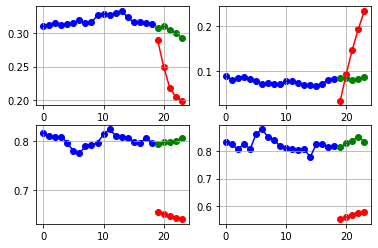

In [11]:
subplots = [221, 222, 223, 224]
plt.figure(1)
for plot_id, i in enumerate(np.random.choice(range(len(x_test)), size=4, replace=False)):
    p1 = np.expand_dims(predicts[i][:,0], axis=-1)
    x1 = np.expand_dims(x_test[i][:,0], axis=-1)
    y1 = np.expand_dims(y_test[i][:,0], axis=-1)
    ff, xx, yy = p1 * norm_constant, x1 * norm_constant, y1 * norm_constant
    plt.subplot(subplots[plot_id])
    plt.grid()
    plot_scatter(range(0, backcast_length), xx, color='b')
    plot_scatter(range(backcast_length, backcast_length + forecast_length), yy, color='g')
    plot_scatter(range(backcast_length, backcast_length + forecast_length), ff, color='r')
plt.show()